In [158]:
#https://rpubs.com/jhofman/nycmaps
!pip install google-cloud-core
!pip install google-cloud-bigquery
!pip install virtualenv
!pip install datalab
 

In [159]:
!pip install --upgrade google-cloud-bigquery[bqstorage,pandas]


Requirement already up-to-date: google-cloud-bigquery[bqstorage,pandas] in c:\tools\anaconda3\lib\site-packages (1.22.0)


In [160]:
os.environ["GOOGLE_APPLICATION_CREDENTIALS"] = "c:\\Users\\antho\\OneDrive\\Documents\\googleKey\\CS-816-2a2543d787f2.json"

In [161]:
from google.cloud import bigquery
import google.cloud.bigquery.magics

from time import sleep

import pandas as pd
import numpy as np

import io, os, pickle, math

import matplotlib.pyplot as plt
import seaborn as sns

In [162]:
bq_query_noaa  = """
    #standardSQL
    SELECT  
        wx.id,
        wx.value,
        wx.element,
        EXTRACT(YEAR FROM wx.date) as year,
        EXTRACT(MONTH FROM wx.date) as month,
        EXTRACT(DAY FROM wx.date) as day,
        EXTRACT(DAYOFWEEK FROM wx.date) as dow,
        wx.date,
        wx.time,  
        s.name
    FROM 
    (
    SELECT id, value, element, date, time FROM `bigquery-public-data.ghcn_d.ghcnd_2019` WHERE element IN ('TMIN','TMAX','PRCP','SNWD')
        UNION ALL
    SELECT id, value, element, date, time FROM `bigquery-public-data.ghcn_d.ghcnd_2018` WHERE element IN ('TMIN','TMAX','PRCP','SNWD')
        UNION ALL
    SELECT id, value, element, date, time FROM `bigquery-public-data.ghcn_d.ghcnd_2017` WHERE element IN ('TMIN','TMAX','PRCP','SNWD')
        UNION ALL
    SELECT id, value, element, date, time FROM `bigquery-public-data.ghcn_d.ghcnd_2016` WHERE element IN ('TMIN','TMAX','PRCP','SNWD')
        UNION ALL
    SELECT id, value, element, date, time FROM `bigquery-public-data.ghcn_d.ghcnd_2015` WHERE element IN ('TMIN','TMAX','PRCP','SNWD')
        UNION ALL
    SELECT id, value, element, date, time FROM `bigquery-public-data.ghcn_d.ghcnd_2014` WHERE element IN ('TMIN','TMAX','PRCP','SNWD')
        UNION ALL
    SELECT id, value, element, date, time FROM `bigquery-public-data.ghcn_d.ghcnd_2013` WHERE element IN ('TMIN','TMAX','PRCP','SNWD')
        UNION ALL
    SELECT id, value, element, date, time FROM `bigquery-public-data.ghcn_d.ghcnd_2012` WHERE element IN ('TMIN','TMAX','PRCP','SNWD')
    ) as wx
    JOIN
        `bigquery-public-data.ghcn_d.ghcnd_stations` s
    ON
        wx.id=s.id
    WHERE 
        s.latitude<=40.940
        AND s.longitude<=-73.717
        and s.state='NY'
"""

bq_query_nypd = """
    #standardSQL
    SELECT
      reason,
      year,
      hour,
      month,
      day,
      dow,
      count(*) incidents
    FROM
        (SELECT 
            contributing_factor_vehicle_1 as reason,
            EXTRACT(YEAR FROM timestamp) as year,
            EXTRACT(MONTH FROM timestamp) as month,
            EXTRACT(HOUR FROM timestamp) as hour,
            EXTRACT(DAY FROM timestamp) as day,
            EXTRACT(DAYOFWEEK FROM timestamp) as dow
          FROM 
            `bigquery-public-data.new_york_mv_collisions.nypd_mv_collisions`
          WHERE
            contributing_factor_vehicle_1 NOT IN ("","Unspecified")) q
    GROUP BY
      reason,
      year,
      hour,
      month,
      day,
      dow
"""

bq_query_nypd_2 = """
    #standardSQL
    SELECT
        hour,
        dow,
        sum(1) incidents,
        count(distinct date) as days
    FROM
        (SELECT 
            CAST(timestamp as DATE) as date,
            EXTRACT(HOUR FROM timestamp) as hour,
            EXTRACT(DAYOFWEEK FROM timestamp) as dow,
            1 as cnt
          FROM 
            `bigquery-public-data.new_york_mv_collisions.nypd_mv_collisions`
          WHERE
            contributing_factor_vehicle_1 NOT IN ("","Unspecified")
            AND EXTRACT(YEAR FROM timestamp)<=2015
            ) q
    GROUP BY
        hour, 
        dow

"""
#google.cloud.bigquery.magics.context.use_bqstorage_api = True
def get_bq_data(query):
    client = bigquery.Client()
    _results = client.query(query)
    return _results
        
def get_data(query):
    client = bigquery.Client()
    dataframe = (
        client.query(query)
        .result()
        .to_dataframe()
    )
    print(dataframe.head())
    return dataframe

In [163]:
results_nypd = get_data(bq_query_nypd)
#results_nypd.head()

                                 reason  year  hour  month  day  dow  \
0      Using On Board Navigation Device  2018    17      1   11    5   
1                 Accelerator Defective  2017    16     10   14    7   
2  Reaction to Other Uninvolved Vehicle  2014    22      8    2    7   
3                Other Lighting Defects  2018    19     10   10    4   
4                      Steering Failure  2018     4      2    2    6   

   incidents  
0          1  
1          1  
2          1  
3          1  
4          1  


In [164]:
results_nypd.head(10)

,reason,year,hour,month,day,dow,incidents
0,Using On Board Navigation Device,2018,17,1,11,5,1
1,Accelerator Defective,2017,16,10,14,7,1
2,Reaction to Other Uninvolved Vehicle,2014,22,8,2,7,1
3,Other Lighting Defects,2018,19,10,10,4,1
4,Steering Failure,2018,4,2,2,6,1
5,Other Electronic Device,2013,11,2,2,7,1
6,Other Electronic Device,2015,19,10,18,1,1
7,Reaction to Other Uninvolved Vehicle,2014,21,1,10,6,1
8,Accelerator Defective,2015,9,9,16,4,1
9,Animals Action,2018,12,1,4,5,1


In [165]:
results_nypd2 = get_data(bq_query_nypd_2)
results_nypd2.head()

   hour  dow  incidents  days
0    18    2       3297   183
1     8    3       3447   183
2     9    2       3217   183
3    20    5       2296   183
4    15    6       3485   182


,hour,dow,incidents,days
0,18,2,3297,183
1,8,3,3447,183
2,9,2,3217,183
3,20,5,2296,183
4,15,6,3485,182


In [166]:
results_nypd2.head(168)

,hour,dow,incidents,days
0,18,2,3297,183
1,8,3,3447,183
2,9,2,3217,183
3,20,5,2296,183
4,15,6,3485,182
5,18,6,3424,182
6,17,2,3725,183
7,12,5,2795,183
8,20,6,2458,182
9,15,7,2595,182


In [167]:
results_noaa = get_data(bq_query_noaa)
results_noaa.head(20)

            id  value element  year  month  day  dow        date  time  \
0  US1NYQN0026   66.0    PRCP  2018      1   24    4  2018-01-24  None   
1  US1NYQN0026  462.0    PRCP  2018      3    2    6  2018-03-02  None   
2  US1NYQN0026    0.0    PRCP  2018      1   14    1  2018-01-14  None   
3  US1NYQN0026    0.0    PRCP  2018      3    9    6  2018-03-09  None   
4  US1NYQN0026    0.0    PRCP  2018      8   27    2  2018-08-27  None   

                             name  
0  JACKSON HEIGHTS 0.3 WSW         
1  JACKSON HEIGHTS 0.3 WSW         
2  JACKSON HEIGHTS 0.3 WSW         
3  JACKSON HEIGHTS 0.3 WSW         
4  JACKSON HEIGHTS 0.3 WSW         


,id,value,element,year,month,day,dow,date,time,name
0,US1NYQN0026,66.0,PRCP,2018,1,24,4,2018-01-24,None,JACKSON HEIGHTS 0.3 WSW
1,US1NYQN0026,462.0,PRCP,2018,3,2,6,2018-03-02,None,JACKSON HEIGHTS 0.3 WSW
2,US1NYQN0026,0.0,PRCP,2018,1,14,1,2018-01-14,None,JACKSON HEIGHTS 0.3 WSW
3,US1NYQN0026,0.0,PRCP,2018,3,9,6,2018-03-09,None,JACKSON HEIGHTS 0.3 WSW
4,US1NYQN0026,0.0,PRCP,2018,8,27,2,2018-08-27,None,JACKSON HEIGHTS 0.3 WSW
5,US1NYQN0026,0.0,PRCP,2018,11,2,6,2018-11-02,None,JACKSON HEIGHTS 0.3 WSW
6,US1NYQN0026,5.0,PRCP,2018,4,10,3,2018-04-10,None,JACKSON HEIGHTS 0.3 WSW
7,US1NYQN0026,23.0,PRCP,2018,4,20,6,2018-04-20,None,JACKSON HEIGHTS 0.3 WSW
8,US1NYQN0026,0.0,PRCP,2018,3,1,5,2018-03-01,None,JACKSON HEIGHTS 0.3 WSW
9,US1NYQN0026,0.0,PRCP,2018,3,12,2,2018-03-12,None,JACKSON HEIGHTS 0.3 WSW


In [168]:
results_noaa.head(10)

,id,value,element,year,month,day,dow,date,time,name
0,US1NYQN0026,66.0,PRCP,2018,1,24,4,2018-01-24,None,JACKSON HEIGHTS 0.3 WSW
1,US1NYQN0026,462.0,PRCP,2018,3,2,6,2018-03-02,None,JACKSON HEIGHTS 0.3 WSW
2,US1NYQN0026,0.0,PRCP,2018,1,14,1,2018-01-14,None,JACKSON HEIGHTS 0.3 WSW
3,US1NYQN0026,0.0,PRCP,2018,3,9,6,2018-03-09,None,JACKSON HEIGHTS 0.3 WSW
4,US1NYQN0026,0.0,PRCP,2018,8,27,2,2018-08-27,None,JACKSON HEIGHTS 0.3 WSW
5,US1NYQN0026,0.0,PRCP,2018,11,2,6,2018-11-02,None,JACKSON HEIGHTS 0.3 WSW
6,US1NYQN0026,5.0,PRCP,2018,4,10,3,2018-04-10,None,JACKSON HEIGHTS 0.3 WSW
7,US1NYQN0026,23.0,PRCP,2018,4,20,6,2018-04-20,None,JACKSON HEIGHTS 0.3 WSW
8,US1NYQN0026,0.0,PRCP,2018,3,1,5,2018-03-01,None,JACKSON HEIGHTS 0.3 WSW
9,US1NYQN0026,0.0,PRCP,2018,3,12,2,2018-03-12,None,JACKSON HEIGHTS 0.3 WSW


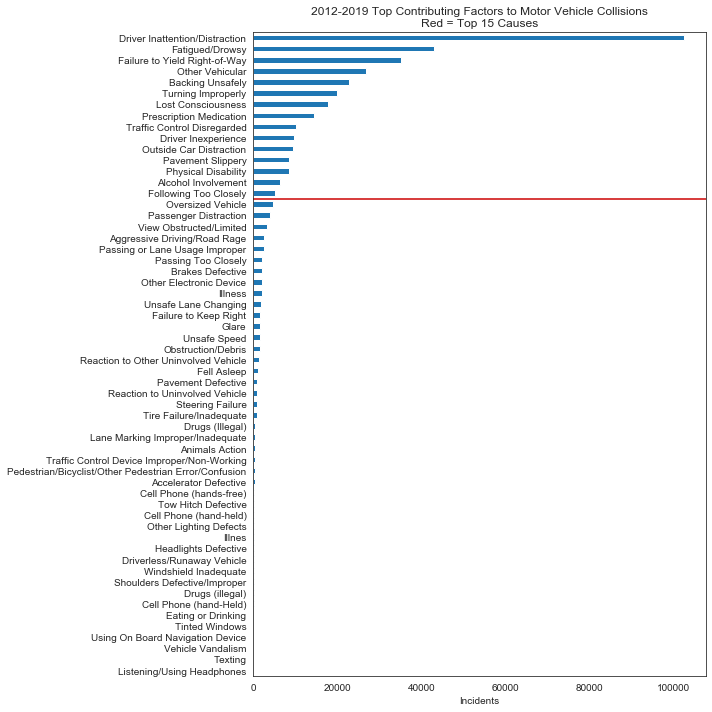

In [187]:
def plot_top_causes(data):
    d = data[(data['year']<=2015) | ((data['month'] <=3) & (data['year']==2019))]
    d = d.groupby('reason').agg({'incidents': np.sum}).sort_values(by='incidents')
    d.plot(kind='barh', legend=False, figsize=(10,10))
    plt.title('2012-2019 Top Contributing Factors to Motor Vehicle Collisions\nRed = Top 15 Causes')
    plt.xlabel('Incidents')
    plt.ylabel('')
    plt.axhline(len(d)-15.5, color='#CC0000')
    plt.tight_layout()
    plt.savefig('nypd_largest_reasons.jpg', dpi=80)

plot_top_causes(results_nypd)

In [188]:
data = results_nypd
d = data[(data['year']<=2015) | ((data['month'] <=3) & (data['year']==2019))]
d.year.min()

2012

In [171]:

def combine_data(data_noaa, data_nypd):
    
    # Prepare NOAA data
    cols = ['date','day','year','month','dow','id']
    
    d_prcp = data_noaa[data_noaa['element'] == 'PRCP'].groupby(cols).agg({'value': np.sum}).reset_index().rename(columns={'value': 'PRCP'})
    d_tmax = data_noaa[data_noaa['element'] == 'TMAX'].groupby(cols).agg({'value': np.max}).reset_index().rename(columns={'value': 'TMAX'})
    d_tmin = data_noaa[data_noaa['element'] == 'TMIN'].groupby(cols).agg({'value': np.min}).reset_index().rename(columns={'value': 'TMIN'})
    d_snwd = data_noaa[data_noaa['element'] == 'SNWD'].groupby(cols).agg({'value': np.max}).reset_index().rename(columns={'value': 'SNWD'})
        
    d_noaa = d_prcp.merge(d_tmax, on=cols, how='outer')
    d_noaa = d_noaa.merge(d_tmin, on=cols, how='outer')
    d_noaa = d_noaa.merge(d_snwd, on=cols, how='outer')
    
    d_noaa = d_noaa.groupby(['date','day','year','month','dow']).agg(np.median).reset_index().fillna(0)
    d_noaa['TMAX'] = (d_noaa['TMAX'] / 10) * (9/5) + 32
    d_noaa['TMIN'] = (d_noaa['TMAX'] / 10) * (9/5) + 32
    
    # Prepare NYPD data, use top 20 reasons from prior to April 2016
    d_prior = data_nypd[(data_nypd['year']<=2015) | ((data_nypd['month'] <=3) & (data_nypd['year']==2016))]
    top_reasons = d_prior.groupby('reason').agg({'incidents': np.sum}).nlargest(20, columns='incidents').index.values
    
    d_nypd = data_nypd.copy()
    d_nypd['reason'] = d_nypd['reason'].apply(lambda x: 'Other' if x not in top_reasons else x)
    
    d_nypd = d_nypd.pivot_table(index=['day','year','month','dow'], 
                                columns='reason', values='incidents', aggfunc='sum').replace(0, np.NaN)
    d_nypd['Total'] = d_nypd.sum(axis=1)
    
    # Merge Results
    d_combined = d_nypd.reset_index().merge(d_noaa, on=['day','year','month','dow'], how='inner')
    d_combined['IsWeekend'] = d_combined['dow'].isin([1,7]).astype(int)

    return d_combined

pvt_combined = combine_data(results_noaa, results_nypd)
pvt_combined.head(5)

,day,year,month,dow,Aggressive Driving/Road Rage,Alcohol Involvement,Backing Unsafely,Driver Inattention/Distraction,Driver Inexperience,Failure to Yield Right-of-Way,...,Traffic Control Disregarded,Turning Improperly,View Obstructed/Limited,Total,date,PRCP,TMAX,TMIN,SNWD,IsWeekend
0,1,2012,7,1,NaN,8.0,21.0,62.0,7.0,16.0,...,8.0,11.0,1.0,233.0,2012-07-01,0.0,95.00,49.1000,0.0,1
1,1,2012,8,4,2.0,3.0,15.0,57.0,10.0,27.0,...,9.0,13.0,1.0,254.0,2012-08-01,81.0,81.05,46.5890,0.0,0
2,1,2012,9,7,1.0,6.0,12.0,52.0,7.0,20.0,...,10.0,9.0,1.0,222.0,2012-09-01,0.0,90.05,48.2090,0.0,1
3,1,2012,10,2,4.0,1.0,9.0,69.0,9.0,18.0,...,5.0,14.0,1.0,230.0,2012-10-01,0.0,71.51,44.8718,0.0,0
4,1,2012,11,5,2.0,3.0,12.0,48.0,2.0,17.0,...,4.0,9.0,NaN,186.0,2012-11-01,0.0,51.98,41.3564,0.0,0


In [172]:
pvt_combined.head(100)

,day,year,month,dow,Aggressive Driving/Road Rage,Alcohol Involvement,Backing Unsafely,Driver Inattention/Distraction,Driver Inexperience,Failure to Yield Right-of-Way,...,Traffic Control Disregarded,Turning Improperly,View Obstructed/Limited,Total,date,PRCP,TMAX,TMIN,SNWD,IsWeekend
0,1,2012,7,1,NaN,8.0,21.0,62.0,7.0,16.0,...,8.0,11.0,1.0,233.0,2012-07-01,0.0,95.00,49.1000,0.0,1
1,1,2012,8,4,2.0,3.0,15.0,57.0,10.0,27.0,...,9.0,13.0,1.0,254.0,2012-08-01,81.0,81.05,46.5890,0.0,0
2,1,2012,9,7,1.0,6.0,12.0,52.0,7.0,20.0,...,10.0,9.0,1.0,222.0,2012-09-01,0.0,90.05,48.2090,0.0,1
3,1,2012,10,2,4.0,1.0,9.0,69.0,9.0,18.0,...,5.0,14.0,1.0,230.0,2012-10-01,0.0,71.51,44.8718,0.0,0
4,1,2012,11,5,2.0,3.0,12.0,48.0,2.0,17.0,...,4.0,9.0,NaN,186.0,2012-11-01,0.0,51.98,41.3564,0.0,0
5,1,2012,12,7,4.0,9.0,9.0,52.0,5.0,19.0,...,5.0,9.0,3.0,188.0,2012-12-01,0.0,41.54,39.4772,0.0,1
6,1,2013,1,3,2.0,12.0,6.0,50.0,3.0,11.0,...,8.0,10.0,3.0,159.0,2013-01-01,0.0,41.00,39.3800,0.0,0
7,1,2013,2,6,5.0,1.0,17.0,63.0,8.0,22.0,...,3.0,12.0,3.0,245.0,2013-02-01,0.0,31.46,37.6628,0.0,0
8,1,2013,3,6,NaN,5.0,11.0,86.0,5.0,21.0,...,3.0,16.0,2.0,262.0,2013-03-01,0.0,44.96,40.0928,0.0,0
9,1,2013,4,2,1.0,5.0,19.0,52.0,5.0,13.0,...,3.0,9.0,1.0,199.0,2013-04-01,9.0,62.06,43.1708,0.0,0


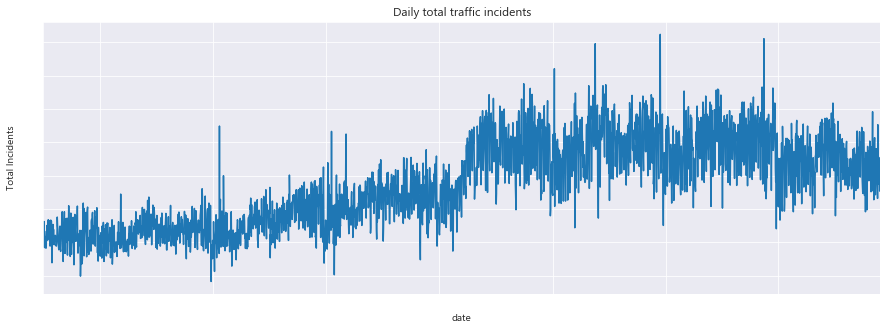

In [173]:
%matplotlib inline

pvt_combined.sort_values(by='date').set_index('date')['Total'].plot(figsize=(15,5))
plt.title('Daily total traffic incidents')
plt.ylabel('Total Incidents');
plt.savefig('nypd_daily_records.jpg', dpi=80)

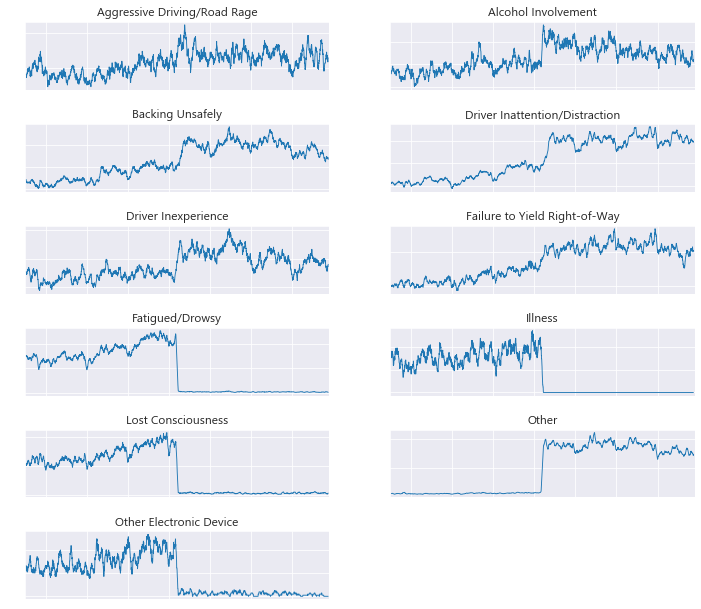

In [174]:

def plot_types(data):
    d = data[[c for c in data.columns if c not in ['day','year','month','dow','PRCP','IsWeekend',
                                                   'TMAX','TMIN','SNWD']]]
    d = d.sort_values(by='date').set_index('date').fillna(0)
    #d = d.apply(lambda x: x.rolling(center=True, window=5))
    d = d.rolling(window=21, center=True, axis=0).mean()

    fig = plt.figure(figsize=(12,20))
    l = math.ceil(len(d.columns)/2)
    for i in range(0, l):
        ax = plt.subplot(l, 2, i+1)
        d.iloc[:,i].plot(ax=ax, linewidth=0.9)
        ax.set_title(d.columns[i])
        ax.set_xlabel('')
        if i < l-2:
            ax.tick_params(labelbottom='off')
        else:
            ax.set_xticklabels(ax.xaxis.get_majorticklabels(), rotation=45)

            
    
    plt.subplots_adjust(hspace=0.5)
    plt.savefig('nypd_daily_records_all.jpg', dpi=80)
    
plot_types(pvt_combined)

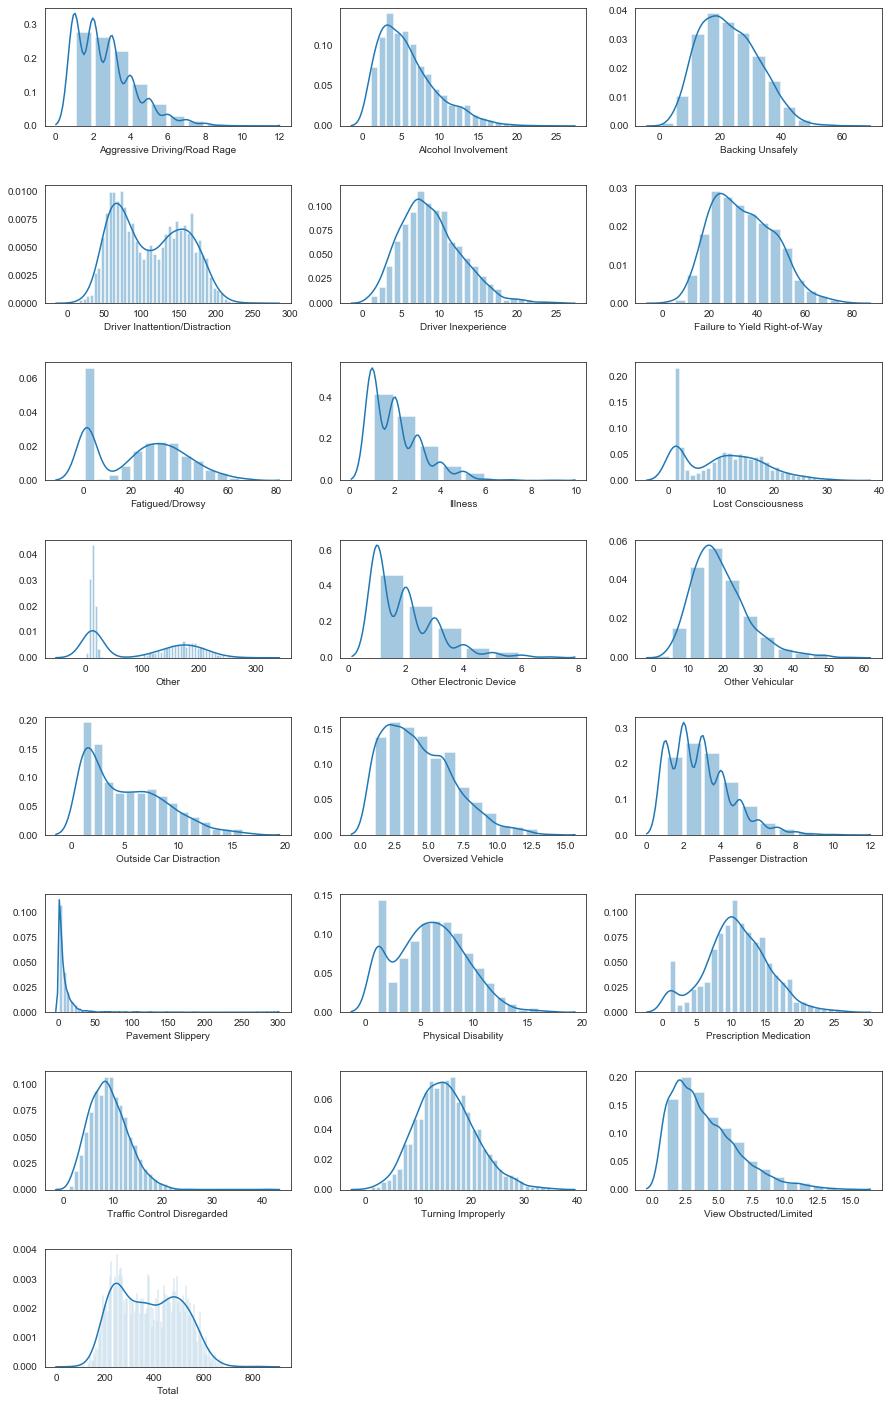

In [175]:

def plot_distributions(data):
    %matplotlib inline
    ds = data[[c for c in data.columns if c not in ['day','year','month','dow','date','TMAX','TMIN','SNWD','PRCP','IsWeekend']]]
    c = 3
    r = math.ceil(len(ds.columns) / c)
    
    sns.set_style('white')
    plt.figure(figsize=(15,25))
    for i in range(0, len(ds.columns)):
        ax = plt.subplot(r, c, i+1)
        d = ds.iloc[:, i].dropna()
        m = int(d.max())

        bins = list(range(0, m, 1 if m<50 else 5))
        sns.distplot(d, ax=ax, bins=bins, hist_kws={'rwidth': 0.8})
        
    plt.subplots_adjust(hspace=0.5)
    plt.savefig('nypd_daily_records_dist.jpg', dpi=80)
    
plot_distributions(pvt_combined)

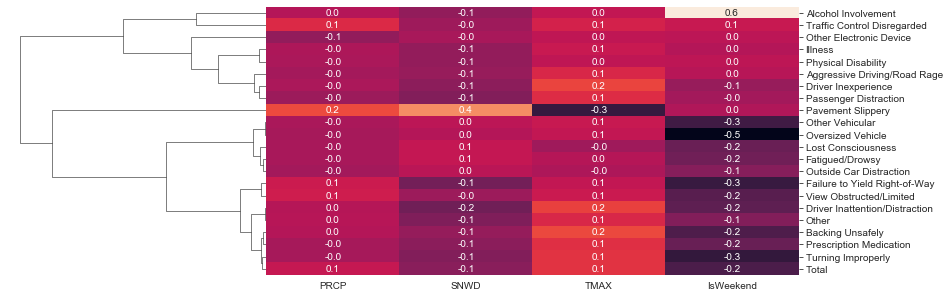

In [184]:
def plot_corr(data):
    # Columns for the heatmap
    cols = ['PRCP','SNWD','TMAX', 'IsWeekend']
    
    d= data[[c for c in data if c not in ['day','year','month','dow','TMIN']]].corr()
    d = d.loc[~d.index.isin(cols), cols] # Prevent creating a triangle effect
    
    %matplotlib inline
    cmap = sns.diverging_palette(220, 20, sep=20, as_cmap=True)
    cm = sns.clustermap(d, col_cluster=False, metric='cosine', method='complete', annot=True, fmt='.1f', figsize=(12,6))
    plt.setp(cm.ax_heatmap.get_yticklabels(), rotation=0)
    
    # Some formatting to remove the column dendograms which take up space regardless. Also format the row dendograms
    cm.cax.set_visible(False)
    cm.ax_col_dendrogram.set_visible(False)
    hm = cm.ax_heatmap.get_position()
    cm.ax_heatmap.set_position([.3, .5, hm.width, hm.height])
    cm.ax_row_dendrogram.set_position([0, .5, .3, hm.height])
    plt.savefig('nypd_daily_records_cormap.jpg', dpi=120)
    plt.show()
    
plot_corr(pvt_combined)




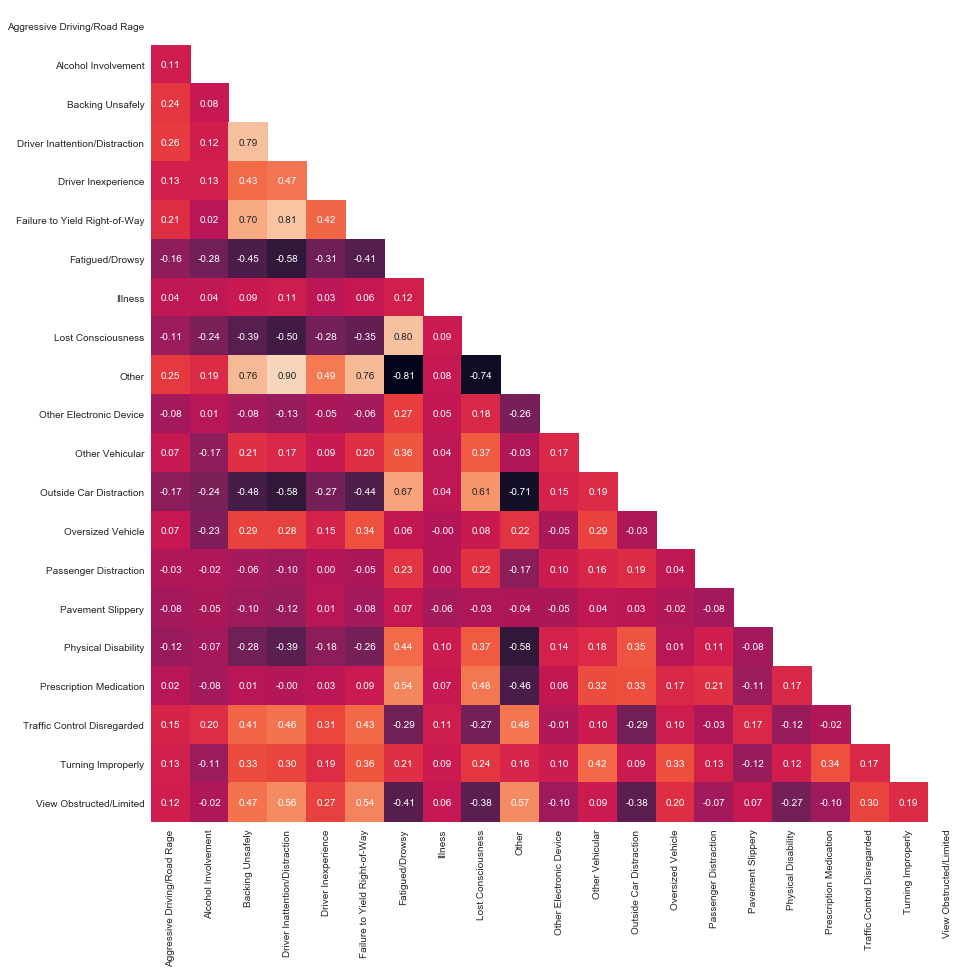

In [143]:
def plot_corr_accident(data):
    d = data[[c for c in data if c not in ['day','year','month','dow','TMIN','TMAX','PRCP','SNWD','Total','IsWeekend']]].corr()
    
    mask = np.zeros_like(d)
    mask[np.triu_indices_from(mask)] = True
    
    %matplotlib inline
    plt.figure(figsize=(15,15))
    with sns.axes_style("white"):
        sns.heatmap(d, cbar=False, square=True, annot=True, fmt='.2f', mask=mask)
        
    plt.savefig('nypd_traffic_corr.jpg', dpi=80)
    
plot_corr_accident(pvt_combined)

C:\tools\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


<Figure size 432x288 with 0 Axes>

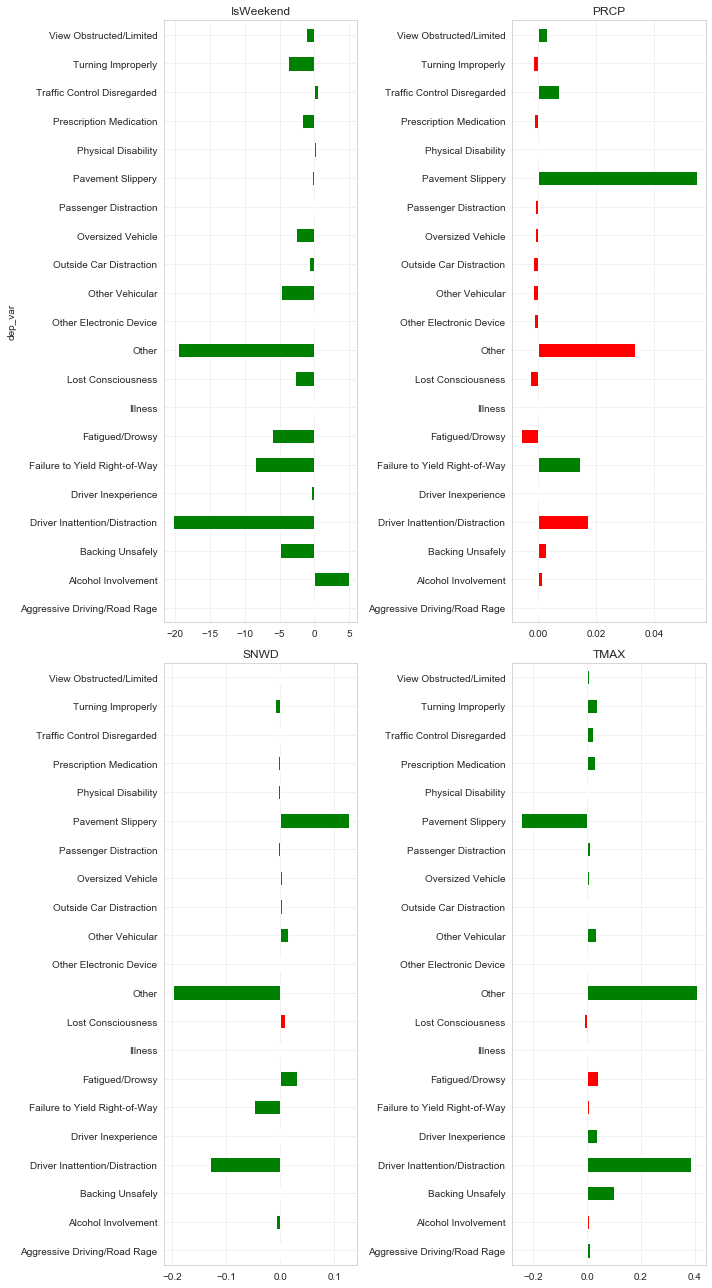

In [144]:

from statsmodels.api import OLS
import statsmodels.api as sm
from sklearn import preprocessing

def plot_regressors(data):
    d = data.copy()
    d['IsWeekend'] = d['dow'].isin([1,7]).astype(int)

    X_cols = ['TMAX','SNWD','PRCP','IsWeekend']
    y_cols = [c for c in data if c not in ['day','year','month','dow','TMIN','TMAX','SNWD','PRCP','Total','date','IsWeekend']]
    
    out = pd.DataFrame()
    for c in y_cols:
        d_filtered = d[~d[c].isnull()]
        X = d_filtered[X_cols]
        X = sm.add_constant(X)
        
        y = d_filtered[c]
        model = OLS(y, X)
        result = model.fit()
        r = result.conf_int()
        r['pa'] = result.params
        r['pv'] = result.pvalues
        r['name'] = c
        
        out = pd.concat([out, r])
        
    out = out.reset_index()   
    out.columns = ['ind_var','cl_lower','cl_upper','coef','pvalue','dep_var']
    out = out[out['ind_var']!='const']
    
    %matplotlib inline
    sns.set_style('whitegrid', {'grid.color': '#EEEEEE'})
    sns.despine()
    plt.figure(figsize=(10,18))
    i=1
    for name, group in out.groupby('ind_var'):
        ax = plt.subplot(2, 2, i)
        c = (group['pvalue']<0.01).map({True: 'green', False: 'red'})
        group.plot(x='dep_var', y='coef', kind='barh', ax=ax, title=name, legend=False, color=c)
        
        if i>1:
            1==1
            #ax.set_yticklabels([])
            #ax.yaxis.set_visible(False)
            ax.set_ylabel('')
        i += 1
    plt.subplots_adjust(wspace=0.9)
    plt.tight_layout()
    plt.savefig('nypd_traffic_reg.jpg', dpi=120)
    return out


reg = plot_regressors(pvt_combined)

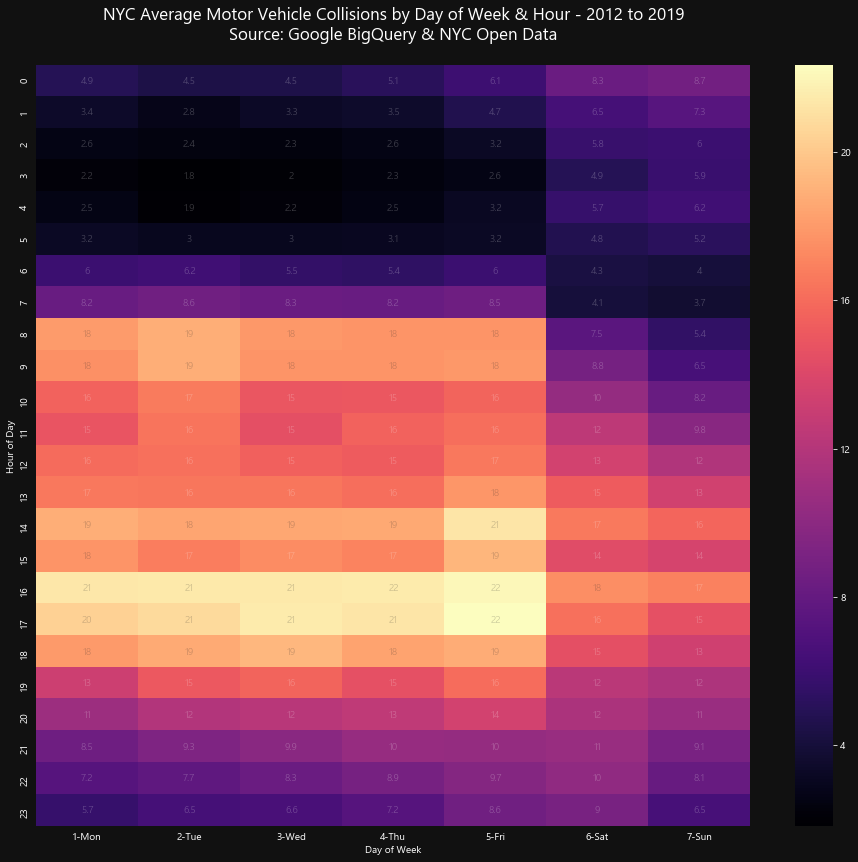

In [147]:
def plot_heatmap(data):
    d = data.copy()
    d['dow'] = d['dow'].map({1: '7-Sun', 2: '1-Mon', 3: '2-Tue', 4:'3-Wed', 5:'4-Thu', 6:'5-Fri', 7:'6-Sat'})
    d['avg'] = d['incidents'] / d['days']
    d = d.pivot(index='hour', columns='dow', values='avg')

    %matplotlib inline

    custom_style = {
        'font.family':'Segoe UI',
        'xtick.color': '#FFFFFF',
        'ytick.color': '#FFFFFF'}
    sns.set_style("darkgrid", rc=custom_style)
    fig = plt.figure(figsize=(16,14),  facecolor='#111111')
    sns.heatmap(d, cmap='magma', cbar=True, annot=True, annot_kws={'size': 10, 'alpha': 0.25, 'family': 'Segoe UI', 'weight': 'light'})
    
    plt.title('NYC Average Motor Vehicle Collisions by Day of Week & Hour - 2012 to 2019\nSource: Google BigQuery & NYC Open Data\n', 
              fontsize=17,  color='white')
    plt.xlabel("Day of Week", color='white')
    plt.ylabel("Hour of Day", color='white')
    plt.savefig('nypd-heatmap-out.png', facecolor=fig.get_facecolor(), transparent=True, dpi=150)

    
plot_heatmap(results_nypd2)